* Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
* Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
* Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
* В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
* Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Qp,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!
* Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16∣∣y^rT|T+i−yrT+i∣∣.
* Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
* Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from IPython.display import clear_output, display
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from sklearn.linear_model import LinearRegression as LR
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
from ipywidgets import IntProgress

**Кластеризуем ряды:**

Shape: (720, 101)


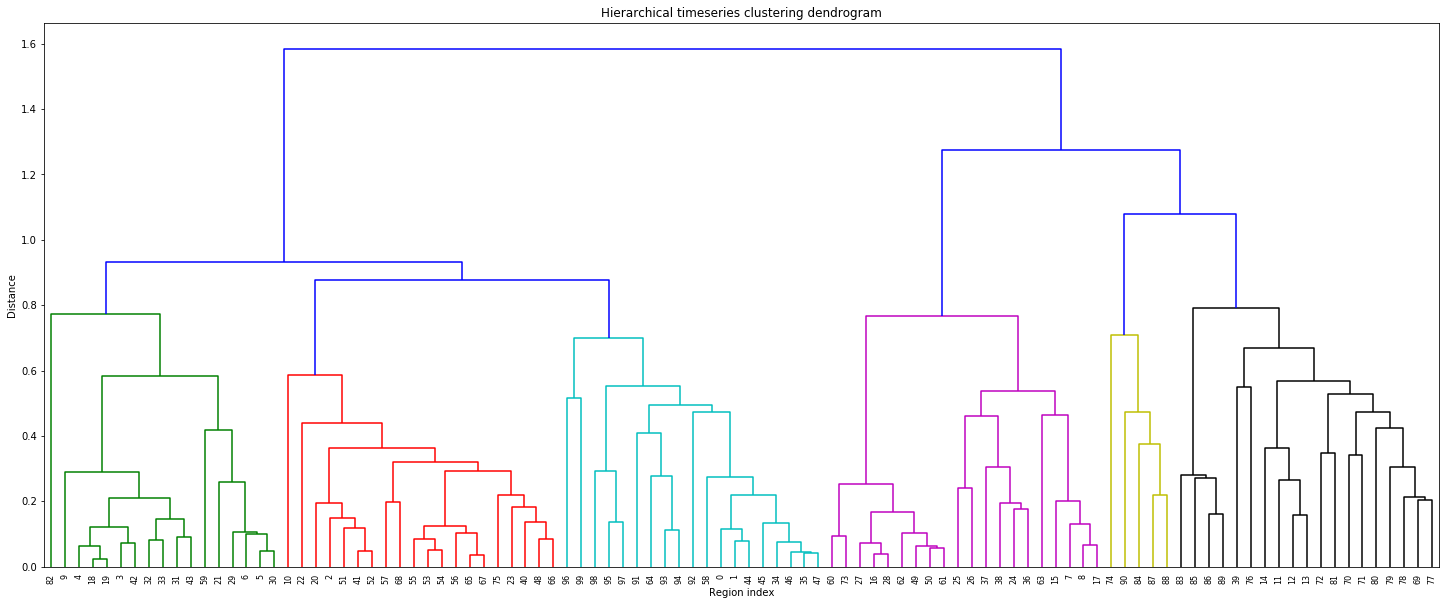

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/agregated/agr_yellow_tripdata_2016-04.csv'
data = pd.read_csv(data_path)
data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)

time_column = data.time
high_load_zones = data.mean().loc[data.mean() >= 5].index
data = data[high_load_zones]
data = (data - data.mean())/data.std()
data = pd.concat([time_column, data], axis=1)
print "Shape:", data.shape

Z = hac.linkage(data.drop('time', axis=1).T, method='complete', metric='correlation')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical timeseries clustering dendrogram')
plt.xlabel('Region index')
plt.ylabel('Distance')
hac.dendrogram(
    Z,
    truncate_mode='none',
    leaf_rotation=90., 
    leaf_font_size=8.,  
    color_threshold=0.8
)

plt.show()

**Посмотрим на кластеры:**

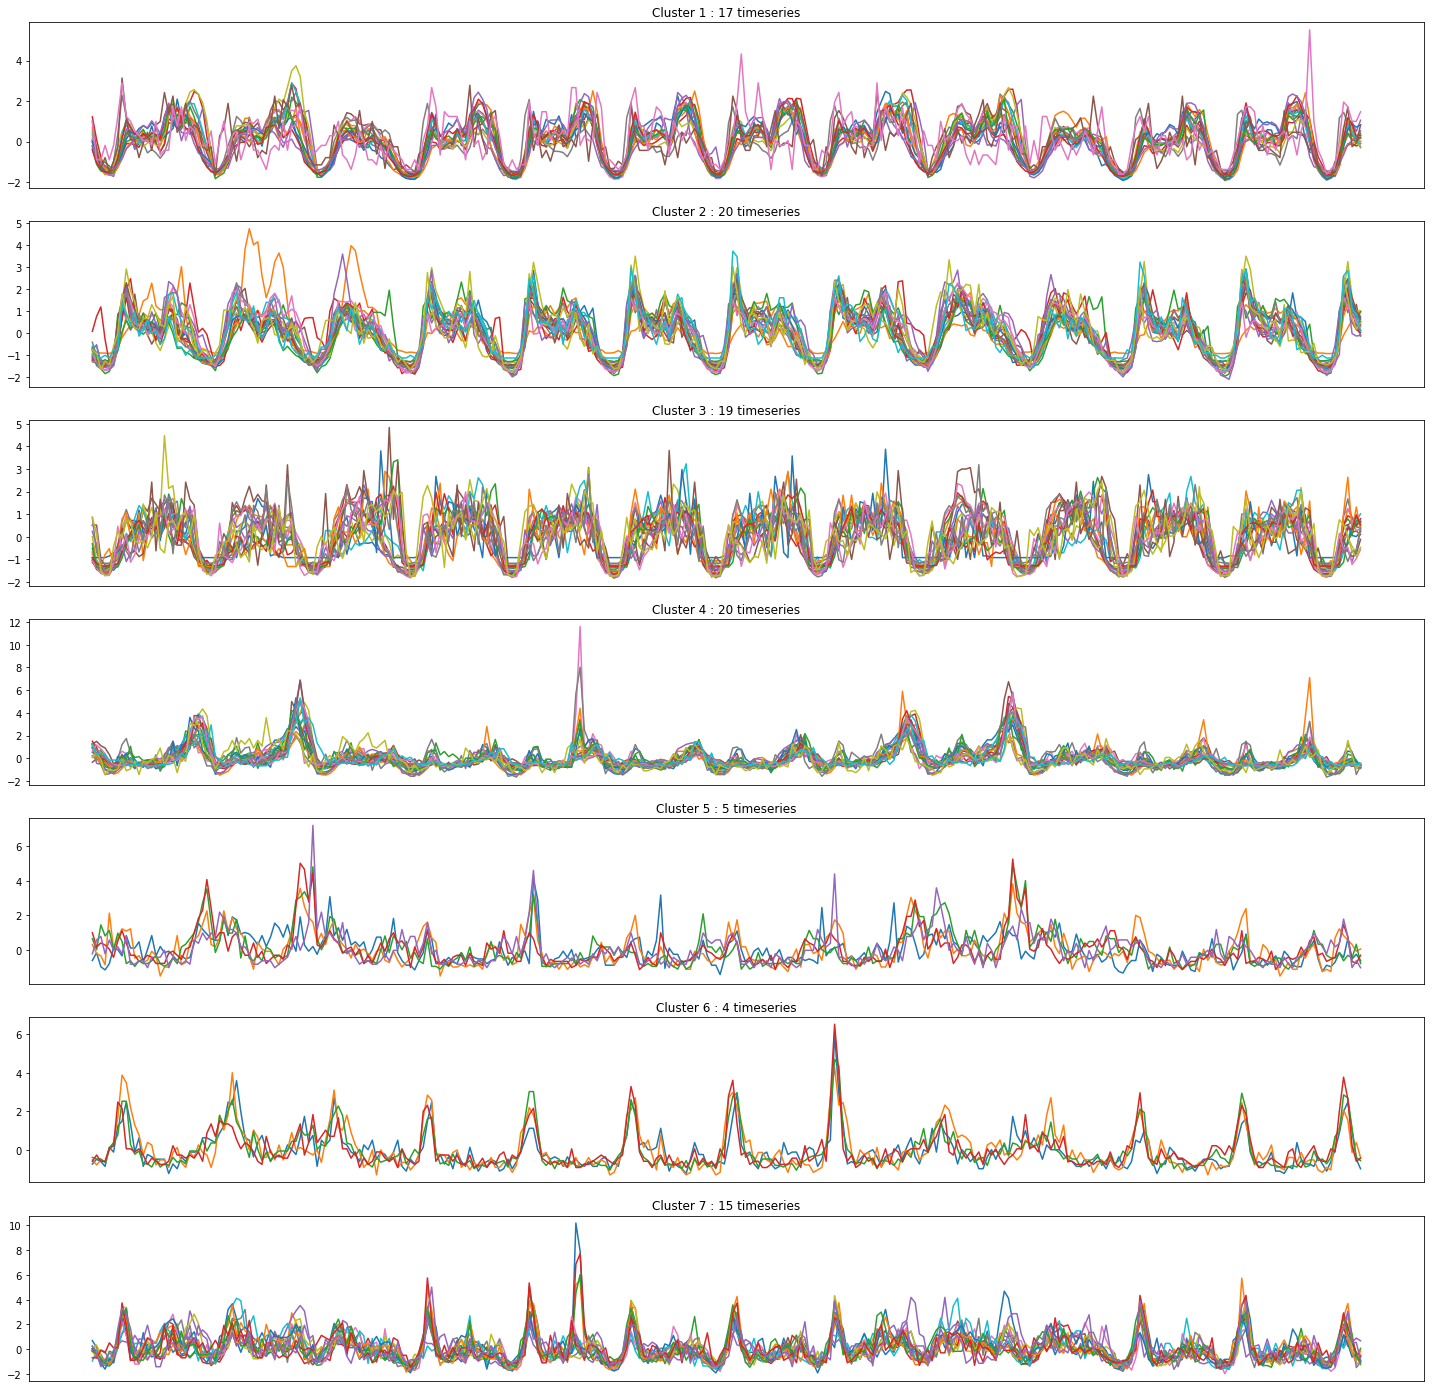

In [0]:
clusters_num   = 7
cluster_tags   = hac.fcluster(Z, clusters_num, criterion='maxclust')
clustered_dict = defaultdict()

for cluster_id in np.unique(cluster_tags):
  clustered_dict[cluster_id] = data.drop('time', axis=1).columns[np.where(cluster_tags == cluster_id)]

fig, ax = plt.subplots(clusters_num, figsize=(25, 25))
i = 0 

for cluster_id in clustered_dict.keys():
  for cluster in data[clustered_dict[cluster_id]]:
    ax[i].plot(data.time[:300], data[cluster][:300])
    
  ax[i].set_title('Cluster {0} : {1} timeseries'.format(cluster_id, len(clustered_dict[cluster_id])))
  ax[i].set_xticks([])
  i += 1

**Теперь нужно для каждого кластера выявить типичный ряд. В каждом кластере я буду искать такой ряд, который наиболее сильно коррелирует с другими рядами:**

In [0]:
typical_regions = []

for cluster_id in clustered_dict.keys():
  typical_regions.append(data[clustered_dict[cluster_id]].corr(method='spearman').sum().idxmax())

typical_regions


['Region_1230',
 'Region_1333',
 'Region_1283',
 'Region_1227',
 'Region_1533',
 'Region_1530',
 'Region_1387']

**Загружаем агрегированные данные, а затем для каждого типичного времянного ряда генерируем регрессионные признаки, вычисляем начальные приближения для аримы:**

In [0]:
datasets_path = '/content/drive/My Drive/Colab Notebooks/data/agregated/'
data_files    = sorted(os.listdir(datasets_path))

def make_dataset(data_files, region, month_amount):
  datasets = []
  for file in data_files[-month_amount-1:len(data_files)-1]:
    dataset = pd.read_csv(datasets_path + file)
    dataset = dataset[['Unnamed: 0', region]]
    dataset.columns = ['time', 'trips']
    dataset.time = pd.to_datetime(dataset.time)
    datasets.append(dataset)
  
  data = pd.concat(datasets)
  data['ind'] = range(1, data.shape[0] + 1)
  data = data.set_index('ind')
    
  return data

typical_datasets = defaultdict()

for region in typical_regions:
  typical_datasets[region]= make_dataset(data_files, region, 1)

print "{0} datasets created: {1}".format(len(typical_datasets.keys()), typical_datasets.keys())


7 datasets created: ['Region_1333', 'Region_1227', 'Region_1283', 'Region_1230', 'Region_1387', 'Region_1533', 'Region_1530']


In [0]:
def generate_feats(df, k):
  feat_columns = []
  for i in range(1, k+1):
    sin_feat_name = 'week_sin_' + str(i)
    cos_feat_name = 'week_cos_' + str(i)
    pol_feat_name = 'pol' + str(i)
    feat_columns.append(sin_feat_name)
    feat_columns.append(cos_feat_name)
    feat_columns.append(pol_feat_name)
    if sin_feat_name not in df.columns:
      df[sin_feat_name] = np.sin(np.array(df.index) * 2 * np.pi * i / 168)
    if cos_feat_name not in df.columns:
      df[cos_feat_name] = np.cos(np.array(df.index) * 2 * np.pi * i / 168)
    if pol_feat_name not in df.columns:
      df[pol_feat_name] = np.array(df.index) ** i

  return feat_columns

In [0]:
data_path = ['/content/drive/My Drive/Colab Notebooks/data/agregated/agr_yellow_tripdata_2016-04.csv',
             '/content/drive/My Drive/Colab Notebooks/data/agregated/agr_yellow_tripdata_2016-05.csv',
             '/content/drive/My Drive/Colab Notebooks/data/agregated/agr_yellow_tripdata_2016-06.csv']

may_df = pd.read_csv(data_path[1])
target_cols = may_df.mean().loc[may_df.mean() >= 5].index
target_cols = target_cols.insert(0, 'time')

data = pd.DataFrame()

for path in data_path:
  month_df = pd.read_csv(path)
  month_df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
  month_df.time = pd.to_datetime(month_df.time)
  time_column = month_df.time
  month_df = month_df[target_cols]
  data = data.append(month_df)
  
regions_df = defaultdict()
  
for region in data.columns[1:]:
  regions_df[region] = data[['time', region]]

for region in regions_df.keys():
  regions_df[region].columns = ['time', 'trips']
  feats = generate_feats(regions_df[region], 7)
  X = np.array(regions_df[region][feats])
  y = np.array(regions_df[region].trips)
  linreg = LR().fit(X, y)
  predicts = linreg.predict(regions_df[region][feats])
  regions_df[region]['linreg_predicts'] = np.array(predicts, dtype='float32')
  regions_df[region]['linreg_resid'] = regions_df[region].trips - predicts


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [0]:
def make_difference(diff_data, diff_count, diff_period):
  result = pd.Series(diff_data)
  for _ in range(diff_count):
    result -= result.shift(diff_period)
  
  return result

In [0]:
for region in regions_df.keys():
  regions_df[region] = regions_df[region].reset_index()
  regions_df[region].reindex([i for i in range(regions_df[region].shape[0])])
  regions_df[region].drop('index', axis=1, inplace=True)

In [0]:
regions_df[region]

,time,trips,week_sin_1,week_cos_1,pol1,week_sin_2,week_cos_2,pol2,week_sin_3,week_cos_3,pol3,week_sin_4,week_cos_4,pol4,week_sin_5,week_cos_5,pol5,week_sin_6,week_cos_6,pol6,week_sin_7,week_cos_7,pol7,linreg_predicts,linreg_resid
0,2016-04-01 00:00:00,158,0.000000,1.000000e+00,0,0.000000e+00,1.000000e+00,0,0.000000e+00,1.000000e+00,0,0.000000e+00,1.000000,0,0.000000,1.000000e+00,0,0.000000e+00,1.000000e+00,0,0.000000e+00,1.000000e+00,0,194.893768,-36.893766
1,2016-04-01 01:00:00,3,0.037391,9.993007e-01,1,7.473009e-02,9.972038e-01,1,1.119645e-01,9.937122e-01,1,1.490423e-01,0.988831,1,0.185912,9.825665e-01,1,2.225209e-01,9.749279e-01,1,2.588190e-01,9.659258e-01,1,194.898438,-191.898435
2,2016-04-01 02:00:00,0,0.074730,9.972038e-01,2,1.490423e-01,9.888308e-01,4,2.225209e-01,9.749279e-01,8,2.947552e-01,0.955573,16,0.365341,9.308737e-01,32,4.338837e-01,9.009689e-01,64,5.000000e-01,8.660254e-01,128,194.912186,-194.912189
3,2016-04-01 03:00:00,0,0.111964,9.937122e-01,3,2.225209e-01,9.749279e-01,9,3.302791e-01,9.438833e-01,27,4.338837e-01,0.900969,81,0.532032,8.467242e-01,243,6.234898e-01,7.818315e-01,729,7.071068e-01,7.071068e-01,2187,194.934799,-194.934801
4,2016-04-01 04:00:00,3,0.149042,9.888308e-01,4,2.947552e-01,9.555728e-01,16,4.338837e-01,9.009689e-01,64,5.633201e-01,0.826239,256,0.680173,7.330519e-01,1024,7.818315e-01,6.234898e-01,4096,8.660254e-01,5.000000e-01,16384,194.966049,-191.966050
5,2016-04-01 05:00:00,3,0.185912,9.825665e-01,5,3.653410e-01,9.308737e-01,25,5.320321e-01,8.467242e-01,125,6.801727e-01,0.733052,625,0.804598,5.938202e-01,3125,9.009689e-01,4.338837e-01,15625,9.659258e-01,2.588190e-01,78125,195.005722,-192.005716
6,2016-04-01 06:00:00,6,0.222521,9.749279e-01,6,4.338837e-01,9.009689e-01,36,6.234898e-01,7.818315e-01,216,7.818315e-01,0.623490,1296,0.900969,4.338837e-01,7776,9.749279e-01,2.225209e-01,46656,1.000000e+00,6.123234e-17,279936,195.053589,-189.053582
7,2016-04-01 07:00:00,64,0.258819,9.659258e-01,7,5.000000e-01,8.660254e-01,49,7.071068e-01,7.071068e-01,343,8.660254e-01,0.500000,2401,0.965926,2.588190e-01,16807,1.000000e+00,6.123234e-17,117649,9.659258e-01,-2.588190e-01,823543,195.109436,-131.109434
8,2016-04-01 08:00:00,148,0.294755,9.555728e-01,8,5.633201e-01,8.262388e-01,64,7.818315e-01,6.234898e-01,512,9.308737e-01,0.365341,4096,0.997204,7.473009e-02,32768,9.749279e-01,-2.225209e-01,262144,8.660254e-01,-5.000000e-01,2097152,195.173065,-47.173060
9,2016-04-01 09:00:00,215,0.330279,9.438833e-01,9,6.234898e-01,7.818315e-01,81,8.467242e-01,5.320321e-01,729,9.749279e-01,0.222521,6561,0.993712,-1.119645e-01,59049,9.009689e-01,-4.338837e-01,531441,7.071068e-01,-7.071068e-01,4782969,195.244247,19.755748


In [0]:
i = 0

for region in typical_regions:
  fig, ax = plt.subplots(4, figsize=(15, 8))
  fig.suptitle("Timeseries {}".format(i), fontsize=16)
  regions_df[region]['linreg_resid_diff'] = make_difference(regions_df[region].linreg_resid[:720], 1, 24)
  regions_df[region]['linreg_resid_diff'] = make_difference(regions_df[region].linreg_resid_diff[:720], 3, 1)
  decompose = sm.tsa.seasonal_decompose(regions_df[region].linreg_resid_diff.dropna(), freq = 24*7)
  ax[0].plot(regions_df[region].time[25:693], decompose.observed[25:693])
  ax[1].plot(regions_df[region].time[25:693], decompose.seasonal[25:693])
  ax[2].plot(regions_df[region].time[25:693], decompose.trend[25:693])
  ax[3].plot(regions_df[region].time[25:693], decompose.resid[25:693])
  i += 1



/usr/local/lib/python2.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


IndexError: ignored

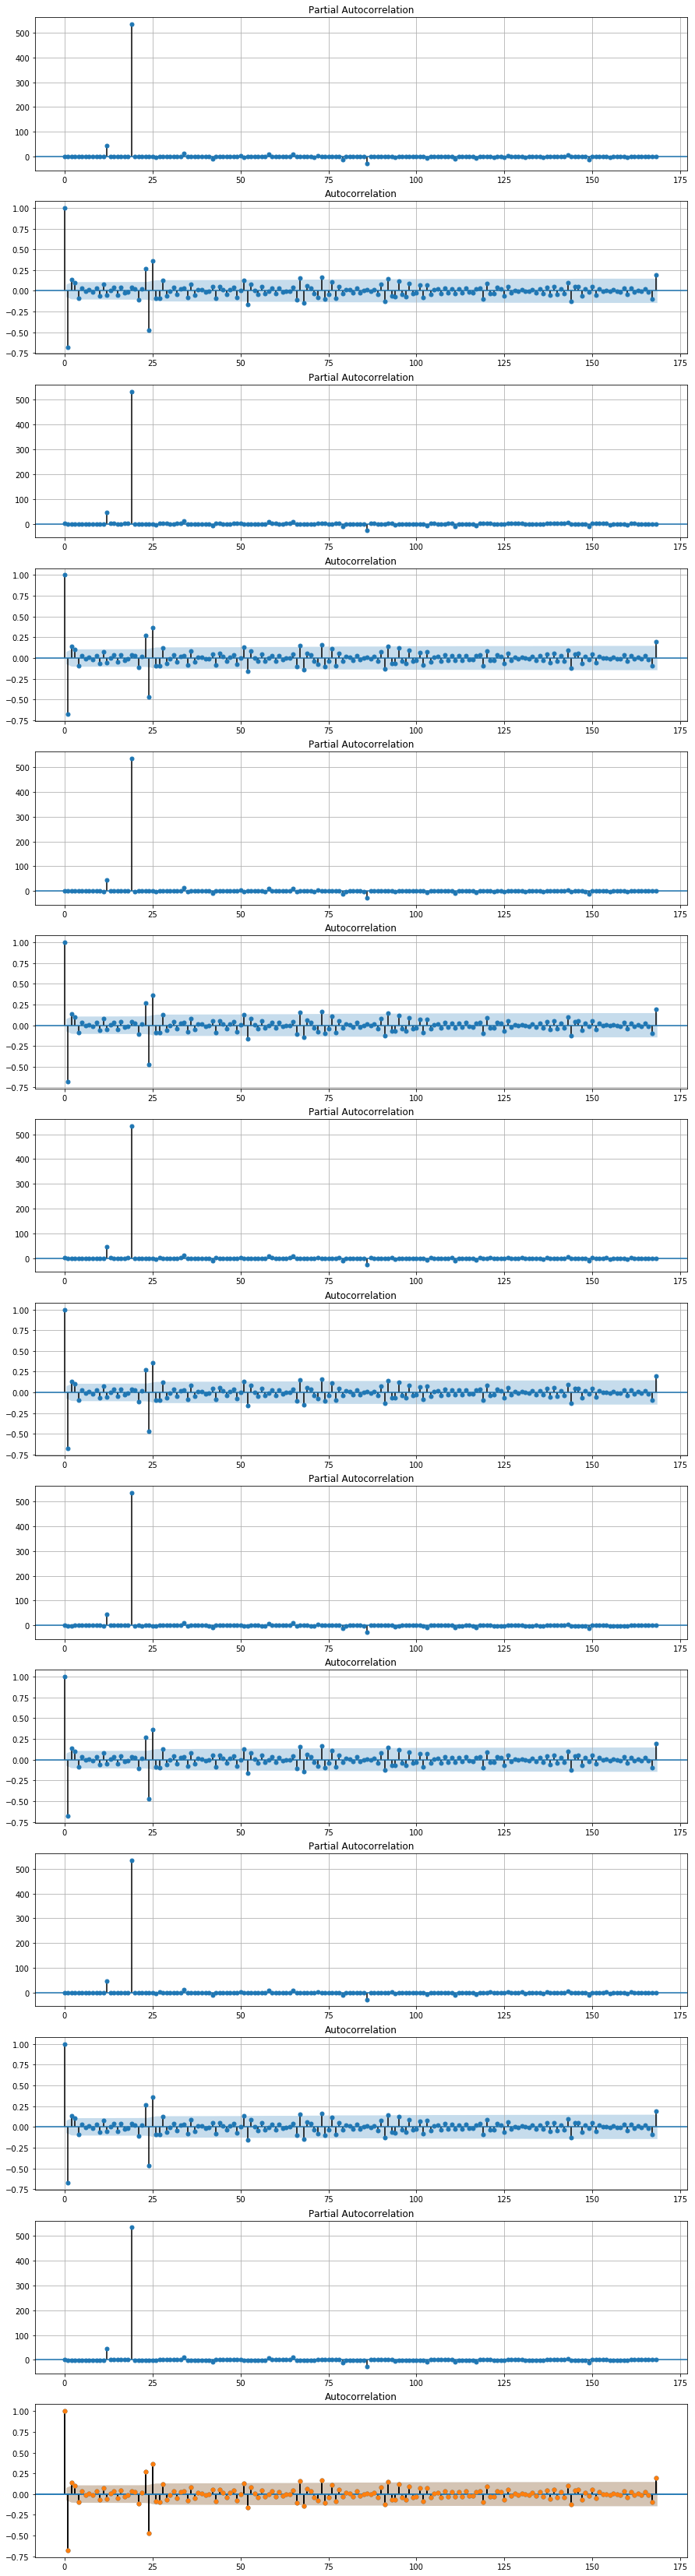

In [0]:
fig, ax = plt.subplots(14, 1, figsize=(15, 60))
i = 0

for regions in typical_regions:
  sm.graphics.tsa.plot_acf(regions_df[region].linreg_resid_diff.dropna().values, lags=24*7, ax=ax[i])
  ax[i].grid()
  i += 1
  sm.graphics.tsa.plot_pacf(regions_df[region].linreg_resid_diff.dropna().values, lags=24*7, ax=ax[i])
  ax[i].grid()
  i += 1

In [0]:
import itertools

p = range(0, 2)
q = range(0, 2)
P = range(0, 1)
Q = range(0, 1)

d=3
D=1

params = itertools.product(p, q, P, Q)
params_list = list(params)
print len(params_list), 'combinations'

4 combinations


In [0]:
%%time

from IPython.display import display, clear_output
from ipywidgets import IntProgress
progress_bar = IntProgress(value=15, min=0, max=7,     \
                           description='Processing...', \
                           bar_style='success')
display(progress_bar)
progress_bar.value = 0
# best_model = defaultdict()
warnings.filterwarnings('ignore')

for region in typical_regions:
  best_aic = float("inf")
  for param in params_list:
      try:
          model=sm.tsa.statespace.SARIMAX(regions_df[region].linreg_resid[:720],
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24)
                                         ).fit(disp=-1)
      except ValueError:
          print('wrong parameters:', param)
          continue
      except LinAlgError:
          print('LinAlgError:', param)
          continue
      aic = model.aic
      if aic < best_aic:
          best_model = model
          best_aic = aic
      progress_bar.value += 1
    
warnings.filterwarnings('default')


IntProgress(value=7, bar_style=u'success', description=u'Processing...', max=7)

CPU times: user 43.6 s, sys: 30.3 s, total: 1min 13s
Wall time: 38 s


In [0]:
def get_typical_params(region):
  if region in typical_regions:
    return best_model[region].params
  else:
    for clust_id in clustered_dict.keys():
      if region in clustered_dict[clust_id]:
        return (best_model[typical_regions[int(clust_id)-1]].params)


In [0]:
# %%time
paint_series = []
error = 0 
steps = 733

progress_bar = IntProgress(value=15, min=0, max=len(regions_df.keys()),
                           description='Processing...',
                           bar_style='success')
progress_bar.value = 0
display(progress_bar)


for region in regions_df.keys():
  start = 719
  stop  = start + 6
  try:
    model_fitted = sm.tsa.statespace.SARIMAX(regions_df[region][:1458].linreg_resid,
                                             order=(1, 1, 1), 
                                             seasonal_order=(0, 1, 0, 24)
                                            ).filter(params = best_model.params)
  except (IndexError):
    print best_model.summary()

  for i in range(steps):
    predict = model_fitted.predict(start, stop-1, dynamic=True)
    try:
      pred = np.array(predict) + np.array(regions_df[region].linreg_predicts[start:stop])
    except (ValueError):
      print start, stop
      print i, region
    error += sum(abs(pred - regions_df[region].trips[start:stop]))
    start += 1
    stop += 1
  progress_bar.value += 1
  
print "Done!"
error /= steps*len(regions_df.keys())*6
print "Error = {}".format(error)


IntProgress(value=0, bar_style=u'success', description=u'Processing...', max=102)

Done!
Error = 38.5705806609


In [0]:
# от 2016.04.30 23:00 до 2016.05.31 17:00 
regions_df[region][719:1458]

In [0]:
%%time

from IPython.display import display, clear_output
from ipywidgets import IntProgress
progress_bar = IntProgress(value=15, min=0, max=7,     \
                           description='Processing...', \
                           bar_style='success')
display(progress_bar)
progress_bar.value = 0
# best_model = defaultdict()
warnings.filterwarnings('ignore')

for region in typical_regions:
  best_aic = float("inf")
  for param in params_list:
      try:
          model=sm.tsa.statespace.SARIMAX(regions_df[region].linreg_resid[:(720+744)],
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24)
                                         ).fit(disp=-1)
      except ValueError:
          print('wrong parameters:', param)
          continue
      except LinAlgError:
          print('LinAlgError:', param)
          continue
      aic = model.aic
      if aic < best_aic:
          best_model = model
          best_aic = aic
      progress_bar.value += 1
    
warnings.filterwarnings('default')


IntProgress(value=7, bar_style=u'success', description=u'Processing...', max=7)

CPU times: user 1min 23s, sys: 59.9 s, total: 2min 23s
Wall time: 1min 14s


In [0]:
# %%time
progress_bar = IntProgress(value=15, min=0, max=len(regions_df.keys()),
                           description='Processing...',
                           bar_style='success')
progress_bar.value = 0
display(progress_bar)

obj_iter = 0
paint_series = []
error = 0 
steps = 715
results = pd.DataFrame(index=[i for i in range(1, 440640+1)], columns=['id', 'y'])
results_path = '/content/drive/My Drive/Colab Notebooks/data/results/'

for region in regions_df.keys():
  filename = results_path + 'results_{}.csv'.format(region.split('_')[1])
  
  if filename not in os.listdir(results_path):
    start = 1463
    stop  = start + 6
    obj_iter = 0
    model_fitted = sm.tsa.statespace.SARIMAX(regions_df[region].linreg_resid,
                                               order=(1, 1, 1), 
                                               seasonal_order=(0, 1, 0, 24)
                                              ).filter(params = best_model.params)
    for i in range(steps):
      model_predicts = model_fitted.predict(start, stop-1, dynamic=True)
      trips_predicts = np.array(model_predicts) + np.array(regions_df[region].linreg_predicts[start:stop])
      for j in range(len(trips_predicts)):
        id_ = '_'.join([region.split('_')[1],
                        regions_df[region].time[start+j].strftime("%Y-%m-%d"),
                        regions_df[region].time[start+j].strftime("%H"),
                        str(j+1)])
        y  = trips_predicts[j]
        results.iloc[obj_iter] = [id_, y]
        obj_iter += 1
      start += 1
      stop += 1
    results.dropna().to_csv(filename)
  
  progress_bar.value += 1
   
print "Done!"


IntProgress(value=0, bar_style=u'success', description=u'Processing...', max=102)

Done!


In [0]:
def f(id):
  if id.split('_')[2][0] == '0':
    id = id[:-4] + id[-3:]
    return id
  else:
    return id
  
def f2(y):
  if y < 0:
    return 0
  else:
    return y

dfs = []
results_path = '/content/drive/My Drive/Colab Notebooks/data/results/'

for file in os.listdir(results_path)[1:-1]:
  dfs.append(pd.read_csv(results_path + file))
  
results_df = pd.concat(dfs)
results_df = results_df.drop('Unnamed: 0', axis=1)
results_df.id = results_df.id.apply(f)
results_df.y  = results_df.y.apply(f2)

objs = ['1075_2016-05-31_23_2',
        '1075_2016-05-31_23_3',
        '1075_2016-05-31_23_4',
        '1075_2016-05-31_23_5',
        '1075_2016-05-31_23_6',
        '1075_2016-06-01_0_3',
        '1075_2016-06-01_0_4',
        '1075_2016-06-01_0_5',
        '1075_2016-06-01_0_6']

for obj in objs:
  df = pd.DataFrame({'id': obj, 
                     'y' : results_df.loc[results_df.id == (obj[:-1] + '1')].y})
  results_df = results_df.append(df, ignore_index=True)

# results_df.to_csv(results_path + 'results.csv', index=False)

In [0]:
def f(id):
  if id.split('_')[2][0] == '0':
    id = id[:-4] + id[-3:]
    return id
  else:
    return id
  
def f2(y):
  if y < 0:
    return 0
  else:
    return y

dfs = []
results_path = '/content/drive/My Drive/Colab Notebooks/data/results/'

for file in os.listdir(results_path)[1:-1]:
  dfs.append(pd.read_csv(results_path + file))
  
results_df = pd.concat(dfs)
results_df = results_df.drop('Unnamed: 0', axis=1)
results_df.id = results_df.id.apply(f)
results_df.y  = results_df.y.apply(f2)



In [0]:
objs = ['_2016-06-30_18_1',
        '_2016-06-30_18_2',
        '_2016-06-30_18_3',
        '_2016-06-30_18_4',
        '_2016-06-30_18_5',
        '_2016-06-30_18_6',
        '_2016-06-30_19_1',
        '_2016-06-30_19_2',
        '_2016-06-30_19_3',
        '_2016-06-30_19_4',
        '_2016-06-30_19_5',
        '_2016-06-30_19_6',
        '_2016-06-30_20_1',
        '_2016-06-30_20_2',
        '_2016-06-30_20_3',
        '_2016-06-30_20_4',
        '_2016-06-30_20_5',
        '_2016-06-30_20_6',
        '_2016-06-30_21_1',
        '_2016-06-30_21_2',
        '_2016-06-30_21_3',
        '_2016-06-30_21_4',
        '_2016-06-30_21_5',
        '_2016-06-30_21_6',
        '_2016-06-30_22_1',
        '_2016-06-30_22_2',
        '_2016-06-30_22_3',
        '_2016-06-30_22_4',
        '_2016-06-30_22_5',
        '_2016-06-30_22_6']

print results_df.shape
for region in regions_df.keys():
  for obj in objs:
    name = region.split('_')[1] + obj
    results_df.drop(results_df.loc[results_df.id == name].index, inplace=True)

print results_df.shape

(437580, 2)
(436050, 2)


In [0]:
objs = ['_2016-05-31_23_2',
        '_2016-05-31_23_3',
        '_2016-05-31_23_4',
        '_2016-05-31_23_5',
        '_2016-05-31_23_6',
        '_2016-06-01_0_3',
        '_2016-06-01_0_4',
        '_2016-06-01_0_5',
        '_2016-06-01_0_6',
        '_2016-06-01_1_4',
        '_2016-06-01_1_5',
        '_2016-06-01_1_6',
        '_2016-06-01_2_5',
        '_2016-06-01_2_6',
        '_2016-06-01_3_6']

for region in regions_df.keys():
  for obj in objs:
    name = region.split('_')[1] + obj
    df = pd.DataFrame({'id': name, 
                       'y' : results_df.loc[results_df.id == (name[:-1] + '1')].y})
    results_df = results_df.append(df, ignore_index=True)

In [0]:
results_df.to_csv(results_path + 'results.csv', index=False)